In [1]:
!pip install -U scikit-image

In [2]:
!pip install pandas

In [ ]:
!git clone https://github.com/pedromperezc/proyecto-especializacion-ceia.git

In [3]:
try:
  
  import detectron2


except ImportError:
  # detectron2  installation
  !pip install pyyaml==5.1
  # workaround: install old version of pytorch since detectron2 hasn't released packages for pytorch 1.9 (issue: https://github.com/facebookresearch/detectron2/issues/3158)

  !pip install torch==1.8.0+cu101 torchvision==0.9.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

  

  !pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html

  exit(0) # restarts runtime


In [4]:
!pip install pandas

In [5]:
# check pytorch installation: 
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
assert torch.__version__.startswith("1.8")   # please manually install torch 1.8 if Colab changes its default version

# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader, build_detection_train_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.structures import BoxMode
import detectron2.data.transforms as T
from detectron2.data import detection_utils as utils
import cv2
import itertools
import copy
import pandas as pandas
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches

setup_logger()

1.8.0+cu101 True


<Logger detectron2 (DEBUG)>

In [6]:
import cv2
import numpy as np
import os
from pathlib import Path
import pickle
import sys

## detectron2
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data import (
    DatasetCatalog,
    MetadataCatalog,
)
from detectron2.engine import DefaultTrainer, DefaultPredictor

from ceia.src import data_utils, visualize

%matplotlib inline

In [7]:
EXPERIMENT_NAME = 'R_50_FPN_3x' # can be 'particle' or 'satellite'
root = Path('ceia','src','datasets') # path to folder  containing labels
json_path_train = Path(root,'train', 'via_project_train_29_10_2021.json')  # path to training data
json_path_val = Path(root,'test', 'via_project_test_29_10_2021.json')  # path to validation data

assert json_path_train.is_file(), 'training file not found!'
assert json_path_val.is_file(), 'validation file not found!'

In [8]:
DatasetCatalog.clear()  # resets catalog, helps prevent errors from running cells multiple times

# store names of datasets that will be registered for easier access later
dataset_train = f'{EXPERIMENT_NAME}_Train'
dataset_valid = f'{EXPERIMENT_NAME}_Val'

# register the training dataset
DatasetCatalog.register(dataset_train, 
                        lambda f = json_path_train: data_utils.get_ddicts(label_fmt='via2',  # annotations generated from vgg image annotator
                                                                          im_root=f,  # path to the training data json file
                                                                          dataset_class='Train'))  # indicates this is training data

# register the validation dataset. Same exact process as above
DatasetCatalog.register(dataset_valid, 
                        lambda f = json_path_val: data_utils.get_ddicts(label_fmt='via2',  # annotations generated from vgg image annotator
                                                                        im_root=f,  # path to validation data json file
                                                                        dataset_class='Validation'))  # indicates this is validation data
print(f'Registered Datasets: {list(DatasetCatalog.data.keys())}')

## There is also a metadata catalog, which stores the class names.
for d in [dataset_train, dataset_valid]:
    MetadataCatalog.get(d).set(**{'thing_classes': [EXPERIMENT_NAME]})

Registered Datasets: ['R_50_FPN_3x_Train', 'R_50_FPN_3x_Val']


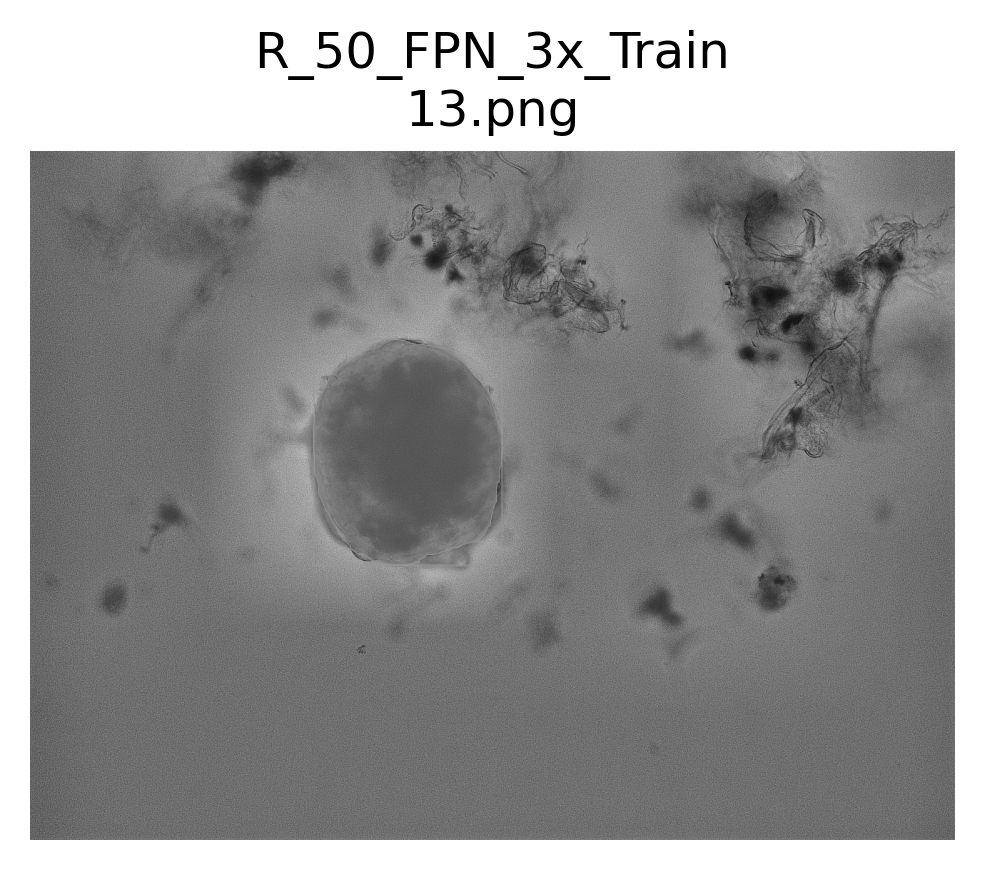

ddict info:
	path: ceia/src/datasets/train/13.png
	num_instances: 1


In [9]:
np.random.seed(42960)
for i in np.random.choice(DatasetCatalog.get(dataset_train), 1, replace=False):
    visualize.display_ddicts(i, None, dataset_train, suppress_labels=True)



In [ ]:
np.random.seed(42960)
for i in np.random.choice(DatasetCatalog.get(dataset_valid), 1, replace=False):
    visualize.display_ddicts(i, None, dataset_valid, suppress_labels=True)

In [10]:
from detectron2.engine.hooks import HookBase
from detectron2.evaluation import inference_context
from detectron2.utils.logger import log_every_n_seconds
from detectron2.data import DatasetMapper, build_detection_test_loader
import detectron2.utils.comm as comm
import torch
import time
import datetime
import logging

class LossEvalHook(HookBase):
    def __init__(self, eval_period, model, data_loader):
        self._model = model
        self._period = eval_period
        self._data_loader = data_loader
    
    def _do_loss_eval(self):
        # Copying inference_on_dataset from evaluator.py
        total = len(self._data_loader)
        num_warmup = min(5, total - 1)
            
        start_time = time.perf_counter()
        total_compute_time = 0
        losses = []
        for idx, inputs in enumerate(self._data_loader):            
            if idx == num_warmup:
                start_time = time.perf_counter()
                total_compute_time = 0
            start_compute_time = time.perf_counter()
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            total_compute_time += time.perf_counter() - start_compute_time
            iters_after_start = idx + 1 - num_warmup * int(idx >= num_warmup)
            seconds_per_img = total_compute_time / iters_after_start
            if idx >= num_warmup * 2 or seconds_per_img > 5:
                total_seconds_per_img = (time.perf_counter() - start_time) / iters_after_start
                eta = datetime.timedelta(seconds=int(total_seconds_per_img * (total - idx - 1)))
                log_every_n_seconds(
                    logging.INFO,
                    "Loss on Validation  done {}/{}. {:.4f} s / img. ETA={}".format(
                        idx + 1, total, seconds_per_img, str(eta)
                    ),
                    n=5,
                )
            loss_batch = self._get_loss(inputs)
            losses.append(loss_batch)
        mean_loss = np.mean(losses)
        self.trainer.storage.put_scalar('validation_loss', mean_loss)
        comm.synchronize()

        return losses
            
    def _get_loss(self, data):
        # How loss is calculated on train_loop 
        metrics_dict = self._model(data)
        metrics_dict = {
            k: v.detach().cpu().item() if isinstance(v, torch.Tensor) else float(v)
            for k, v in metrics_dict.items()
        }
        total_losses_reduced = sum(loss for loss in metrics_dict.values())
        return total_losses_reduced
        
        
    def after_step(self):
        next_iter = self.trainer.iter + 1
        is_final = next_iter == self.trainer.max_iter
        if is_final or (self._period > 0 and next_iter % self._period == 0):
            self._do_loss_eval()
        self.trainer.storage.put_scalars(timetest=12)

In [11]:
def custom_mapper(dataset_dict):
    # Implement a mapper, similar to the default DatasetMapper, but with your own customizations
    dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
    image = utils.read_image(dataset_dict["file_name"], format="BGR")
    transform_list = [T.Resize((800,800)),
                      T.RandomFlip(prob=0.5, horizontal=False, vertical=True),
                      T.RandomFlip(prob=0.5, horizontal=True, vertical=False),
                      T.RandomBrightness(0.9, 1.1),
                      T.RandomContrast(0.9, 1.1),
                      T.RandomRotation(90, expand=True, center=None, sample_style='range', interp=None)
                      ]
    image, transforms = T.apply_transform_gens(transform_list, image)
    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))

    annos = [
        utils.transform_instance_annotations(obj, transforms, image.shape[:2])
        for obj in dataset_dict.pop("annotations")
        if obj.get("iscrowd", 0) == 0
    ]
    instances = utils.annotations_to_instances(annos, image.shape[:2])
    dataset_dict["instances"] = utils.filter_empty_instances(instances)
    return dataset_dict


class WheatTrainer(DefaultTrainer):
    
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=custom_mapper)

In [12]:
class MyTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=custom_mapper)
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name, cfg, True, output_folder)
                     
    def build_hooks(self):
        hooks = super().build_hooks()
        hooks.insert(-1,LossEvalHook(
            cfg.TEST.EVAL_PERIOD,
            self.model,
            build_detection_test_loader(
                self.cfg,
                self.cfg.DATASETS.TEST[0],
                DatasetMapper(self.cfg,True)
            )
        ))
        return hooks

In [34]:
cfg = get_cfg() # initialize cfg object
cfg.merge_from_file(model_zoo.get_config_file('COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml'))  # load default parameters for Mask R-CNN
cfg.INPUT.MASK_FORMAT = 'polygon'  # masks generated in VGG image annotator are polygons
cfg.DATASETS.TRAIN = (dataset_train,)  # dataset used for training model
cfg.DATASETS.TEST = (dataset_train, dataset_valid)  # we will look at the predictions on both sets after training
cfg.SOLVER.IMS_PER_BATCH = 8 # number of images per batch (across all machines)
cfg.SOLVER.CHECKPOINT_PERIOD = 2000  # number of iterations after which to save model checkpoints
cfg.MODEL.DEVICE='cpu'  # 'cpu' to force model to run on cpu, 'cuda' if you have a compatible gpu
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1 # Since we are training separate models for particles and satellites there is only one class output
cfg.TEST.DETECTIONS_PER_IMAGE = 1  # maximum number of instances that can be detected in an image (this is fixed in mask r-cnn)
cfg.SOLVER.MAX_ITER = 10000  # maximum number of iterations to run during training
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.TEST.EVAL_PERIOD = 100
num_gpu = 1
bs = (num_gpu * 2)
cfg.SOLVER.BASE_LR = 0.00025
  # Increasing this may improve the training results, but will take longer to run (especially without a gpu!)

# model weights will be downloaded if they are not present
weights_path = Path('storage','model_final_f10217.pkl')
if weights_path.is_file():
    print('Using locally stored weights: {}'.format(weights_path))
else:
    weights_path = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
    print('Weights not found, weights will be downloaded from source: {}'.format(weights_path))
cfg.MODEL.WEIGHTs = str(weights_path)
cfg.OUTPUT_DIR = str(Path('storage', f'{EXPERIMENT_NAME}_output'))
# make the output directory
os.makedirs(Path(cfg.OUTPUT_DIR), exist_ok=True)
#trainer = WheatTrainer(cfg)
trainer = MyTrainer(cfg)


Weights not found, weights will be downloaded from source: https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl
[11/02 03:10:34 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1

## Augmentación
La función build_train_loader generará transformaciones en las imagenes al momento de entregar. Las transformaciones fueron definidas en la función custom_mapper:

**Listado de transformaciones:**

* T.Resize(800,800)
* T.RandomFlip(prob=0.5, horizontal=False, vertical=True)
* T.RandomFlip(prob=0.5, horizontal=True, vertical=False)
* T.RandomBrightness(0.9, 1.1)
* T.RandomContrast(0.9, 1.1)
* T.RandomRotation(90, expand=True, center=None, sample_style='range', interp=None)


In [ ]:
train_data_loader = trainer.build_train_loader(cfg)
data_iter = iter(train_data_loader)
batch = next(data_iter)

In [ ]:
# Visualizamos una transformación
rows, cols = 1, 2
plt.figure(figsize=(20,20))

for i, per_image in enumerate(batch[:2]):
    print (i)
    plt.subplot(rows, cols, i+1)
    
    # Pytorch tensor is in (C, H, W) format
    img = per_image["image"].permute(1, 2, 0).cpu().detach().numpy()
    img = utils.convert_image_to_rgb(img, cfg.INPUT.FORMAT)

    visualizer = Visualizer(img, scale=0.5)

    target_fields = per_image["instances"].get_fields()
    labels = None
    vis = visualizer.overlay_instances(
        labels=labels,
        boxes=target_fields.get("gt_boxes", None),
        masks=target_fields.get("gt_masks", None),
        keypoints=target_fields.get("gt_keypoints", None),
    )
    plt.imshow(vis.get_image()[:, :, ::-1])

## Entranamiento del modelo:

In [ ]:
# note this cell generates a huge wall of text
# trainer = DefaultTrainer(cfg)  # create trainer object from cfg
#trainer.resume_or_load(resume=True)  # start training from iteration 0
#trainer.train()  # train the model!

## Loss cost:

In [ ]:
import json
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
experiment_folder = './storage/R_50_FPN_3x_output'

def load_json_arr(json_path):
    lines = []
    with open(json_path, 'r') as f:
        for line in f:
            lines.append(json.loads(line))
    return lines

experiment_metrics = load_json_arr(experiment_folder + '/metrics.json')

plt.plot(
    [x['iteration'] for x in experiment_metrics[:-1]], 
    [x['total_loss'] for x in experiment_metrics[:-1]])
plt.plot(
    [x['iteration'] for x in experiment_metrics[:-1] if 'validation_loss' in x], 
    [x['validation_loss'] for x in experiment_metrics[:-1] if 'validation_loss' in x])
plt.legend(['total_loss', 'validation_loss'], loc='upper left')
plt.show()

**Se observa que apartir de la iteración 4000 el costo en el set de validación no desciende.**

## Modelo

In [35]:
cfg.OUTPUT_DIR

'storage/R_50_FPN_3x_output'

In [36]:
# load the weights of the model we want to use 
model_checkpoints = sorted(Path(cfg.OUTPUT_DIR).glob('*.pth'))  # paths to weights saved druing training
cfg.DATASETS.TEST = (dataset_train, dataset_valid)  # predictor requires this field to not be empty
cfg.MODEL.WEIGHTS = str(model_checkpoints[-1])  # use the last model checkpoint saved during training. If you want to see the performance of other checkpoints you can select a different index from model_checkpoints.
predictor = DefaultPredictor(cfg)  # create predictor object

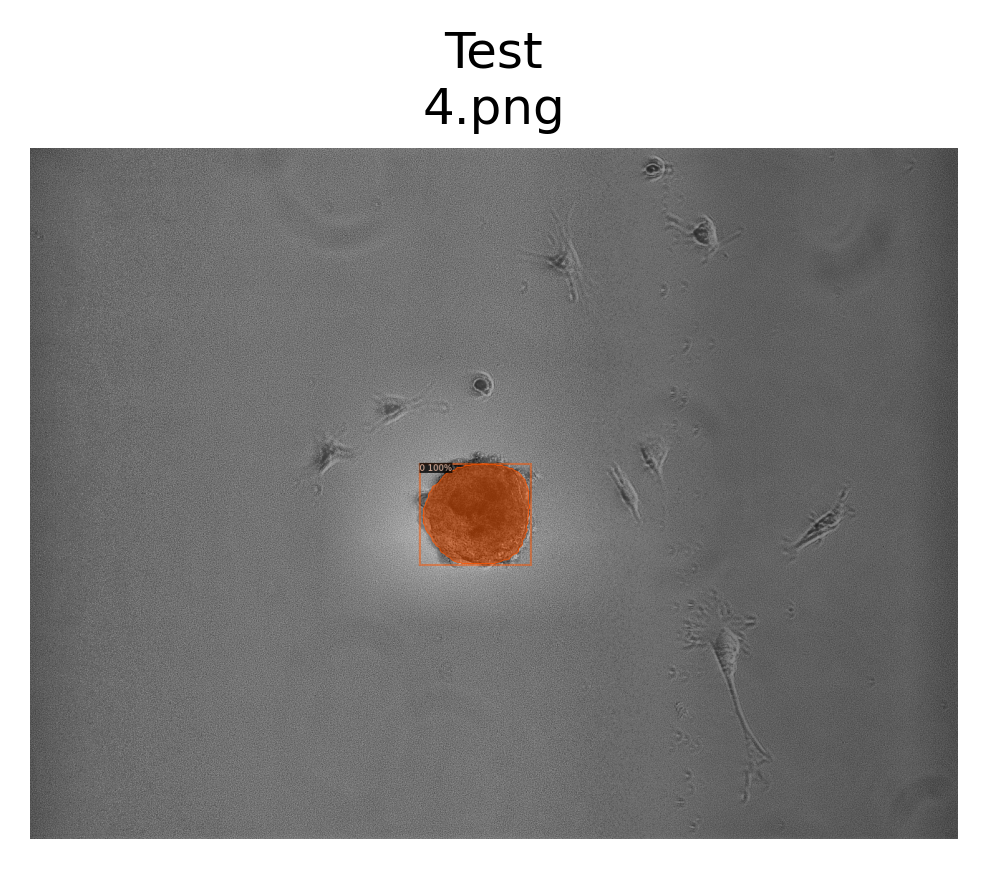

ddict info:
	path: ceia/src/datasets/test/4.png
	num_instances: 1


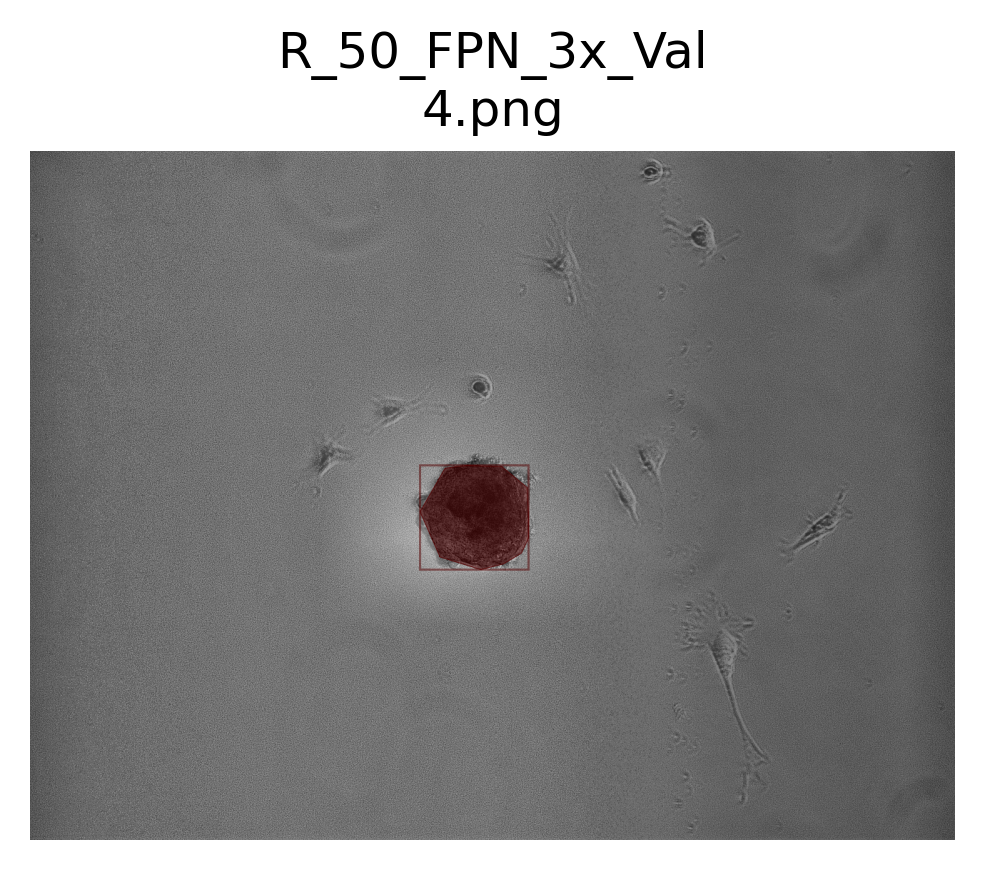

ddict info:
	path: ceia/src/datasets/test/4.png
	num_instances: 1


In [37]:
img_path = Path(root,'test', '4.png')
img = cv2.imread(str(img_path))
outs = predictor(img)
data_utils.format_outputs(img_path, dataset='test', pred=outs)
visualize.display_ddicts(ddict=outs,  # predictions to display
                                 outpath=None, dataset='Test',  # don't save figure
                                 gt=False,  # specifies format as model predictions
                                img_path=img_path)  # path to image
visualize.display_ddicts(DatasetCatalog.get(dataset_valid)[1], None, dataset_valid, suppress_labels=True)

In [ ]:
# Evaluate the model
evaluator = COCOEvaluator(dataset_valid, cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, dataset_valid)
inference_on_dataset(predictor.model, val_loader, evaluator)

## Exporto configuración del modelo

In [38]:
with open("R_50_FPN_3x_output_model_0005999_torch_gpu.yaml", "w") as f:
  f.write(cfg.dump())   # save config to file

In [39]:
from detectron2.modeling import build_model
from detectron2.checkpoint import DetectionCheckpointer

model = build_model(cfg)
DetectionCheckpointer(model).load(cfg.MODEL.WEIGHTS)


{'trainer': {'iteration': 5999,
  'hooks': {'LRScheduler': {'base_lrs': [0.00025], 'last_epoch': 6000}}},
 'iteration': 5999}

In [19]:
# COCO dataset loader
# from detectron2.export.api import Caffe2Tracer

# data_loader = build_detection_test_loader(cfg, cfg.DATASETS.TEST[0], num_workers=0)
# first_batch = next(iter(data_loader))


In [21]:
# model_torch = tracer.export_torchscript()

In [22]:
# model_torch.save('model_final_R_50_FPN_3x_6000_iter_torch.pt')

In [23]:
# Save model caffe2
# from detectron2.export.api import Caffe2Model
# from detectron2.export.api import add_export_config

# caffe2_cfg = add_export_config(cfg)
# tracer = Caffe2Tracer(caffe2_cfg, model, first_batch)

# caffe2 = Caffe2Model(cfg, tracer)

In [24]:
# caffe2.save_protobuf('storage/R_50_FPN_3x_output')

In [25]:
# model_torch = tracer.export_torchscript()
# model_torch.save('model_final_R_50_FPN_3x_6000_iter_torch.pt')

In [40]:
from detectron2.export import scripting_with_instances
from detectron2.structures import Boxes

model.eval()

fields = {
        "proposal_boxes": Boxes,
        "objectness_logits": torch.Tensor,
        "pred_boxes": Boxes,
        "scores": torch.Tensor,
        "pred_classes": torch.Tensor,
        "pred_masks": torch.Tensor,
        "pred_keypoints": torch.Tensor,
        "pred_keypoint_heatmaps": torch.Tensor,
    }
    
ts_model = scripting_with_instances(model, fields)
with open("model_final_R_50_FPN_3x_6000_iter_torch_cpu.pt", "wb") as f:
        torch.jit.save(ts_model, f)

In [96]:
modelo_torch_prueba = torch.jit.load('model_final_R_50_FPN_3x_6000_iter_torch_cpu.pt')

In [90]:
root = Path('ceia','src','datasets')
img_path = Path(root,'test', '160.png')
img = cv2.imread(str(img_path))
tensor_image = torch.tensor(img)

In [97]:
sample_input = [{"image": tensor_image.permute(2,0,1)}]
scripted_instance = modelo_torch_prueba.inference(sample_input, do_postprocess=False)[0]

In [98]:
boxes = scripted_instance.pred_boxes

In [ ]:
from torchvision inport utils

In [100]:
from torchvision import utils

result = utils.draw_bounding_boxes(img_tensor.permute(2,0, 1), boxes.tensor, fill=True)

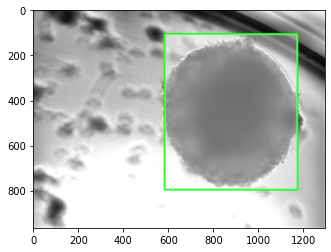

In [101]:
plt.imshow(result.permute(1,2,0))

In [103]:
img_with_masks = utils. draw_segmentation_masks(img, masks=scripted_instance.pred_masks, alpha=0.7)
show(img_with_masks)

AttributeError: module 'torchvision.utils' has no attribute 'draw_segmentation_masks'